In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import numpy as np
stop_words = list(stop_words.ENGLISH_STOP_WORDS) + list(punctuation)
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

from src.data import Newsgroups

In [2]:
hparams = {
    'n_features' : 10000
}

### 20newgroups

In [6]:
data = Newsgroups()

In [7]:
data_dict = {
    'class_weights' : data.class_weights,
    'flat_label_dict' : data.flat_label_dict,
    'hier_label_dict' : data.hier_label_dict,
    'train' : {
        'texts' : data.train_texts,
        'features' : data.train_features,
        'flat_labels' : data.train_flat_labels,
        'hier_labels' : data.train_hier_labels
    },
    'test' : {
        'texts' : data.test_texts,
        'features' : data.test_features,
        'flat_labels' : data.test_flat_labels,
        'hier_labels' : data.test_hier_labels
    }
}

pickle.dump(data_dict, open('data/20newsgroups.pickle', 'wb'))

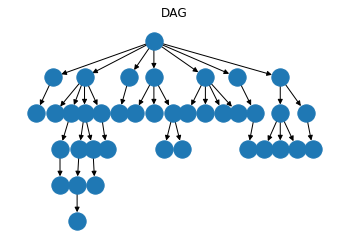

In [8]:
plt.title('DAG')
pos=graphviz_layout(data.tree, prog='dot')
nx.draw(data.tree, pos)
plt.show()

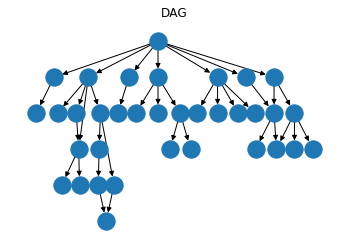

In [9]:
plt.title('DAG')
pos=graphviz_layout(data.dag, prog='dot')
nx.draw(data.dag, pos)
plt.show()

### CIFAR-100

In [2]:
import subprocess
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class Cifar100:
    def __init__(self, batch_size=1024):
        if not os.path.exists('cifar-100-python'):
            if not os.path.exists('cifar-100-python.tar.gz'):
                process = subprocess.Popen('wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'.split(), stdout=subprocess.PIPE)
                output, error = process.communicate()
                if error: print(error)
            process = subprocess.Popen('tar -zxf cifar-100-python.tar.gz'.split(), stdout=subprocess.PIPE)
            output, error = process.communicate()
            if error: print(error)
        
        self.train_images, self.train_flat_labels, self.train_hier_labels = self._parse_data(unpickle('cifar-100-python/train'))
        self.test_images, self.test_flat_labels, self.test_hier_labels = self._parse_data(unpickle('cifar-100-python/test'))
        
        # calculate class weights
        self.class_counts = Counter(self.train_flat_labels)
        self.class_weights = np.array(
            [max(self.class_counts.values())/self.class_counts[i] for i in range(len(self.class_counts))]
        )
        
        # create label dictionaries
        unique_hier_labels = sorted(set(self.train_hier_labels), key=lambda x : x[1])
        
        cifar_meta = unpickle('cifar-100-python/meta')
        cifar_meta['coarse_label_names'] = [x.decode('utf8') for x in cifar_meta[b'coarse_label_names']]
        cifar_meta['fine_label_names'] = [x.decode('utf8') for x in cifar_meta[b'fine_label_names']]
        
        self.flat_label_dict = dict([(y, cifar_meta['coarse_label_names'][x] + '.' + cifar_meta['fine_label_names'][y]) for x, y in unique_hier_labels])
        self.hier_label_dict = [dict(enumerate(cifar_meta['coarse_label_names'])), dict(enumerate(cifar_meta['fine_label_names']))]
        
        # extract features using resnet
        #resnet = models.resnet152(pretrained=True)
        resnet = models.resnet18(pretrained=True)
        self.resnet_vectorizer = torch.nn.Sequential(*(list(resnet.children())[:-1]))
        
        print('Extracting train resnet features...')
        self.train_features = self.extract_resnet_features(self.train_images, batch_size=batch_size)
        print('Extracting test resnet features...')
        self.test_features = self.extract_resnet_features(self.test_images, batch_size=batch_size)
        
    def _parse_data(self, data_obj):
        # extract images
        images = []
        for arr in data_obj[b'data']:
            img = np.zeros((32, 32, 3), dtype=np.uint8)
            img[..., 0] = np.reshape(arr[:1024], (32, 32))
            img[..., 1] = np.reshape(arr[1024:2048], (32, 32))
            img[..., 2] = np.reshape(arr[2048:], (32, 32))
            images.append(img)
        
        # extract labels
        flat_labels, hier_labels = [], []
        for coarse_label, fine_label in zip(data_obj[b'coarse_labels'], data_obj[b'fine_labels']):
            flat_labels.append(fine_label)
            hier_labels.append((coarse_label, fine_label))
        
        return images, flat_labels, hier_labels
    
    def extract_resnet_features(self, images, batch_size=64):
        with torch.no_grad():
            features = []
            ct = 0
            for i in range(int(np.ceil(len(images)/batch_size))):
                batch = np.transpose(images[i*batch_size:(i+1)*batch_size], (0, 3, 1, 2))
                features.append(self.resnet_vectorizer(torch.tensor(batch, dtype=torch.float32)))
                ct += len(batch)
                print(ct, end='\r', flush=True)
            features = np.concatenate(features, axis=0).squeeze(-1).squeeze(-1)
            return features

In [3]:
cifar100 = Cifar100(batch_size=2048)

Extracting train resnet features...
Extracting test resnet features...


In [17]:
# data = {
#     'class_weights' : cifar100.class_weights,
#     'flat_label_dict' : cifar100.flat_label_dict,
#     'hier_label_dict' : cifar100.hier_label_dict,
#     'train' : {
#         'images' : cifar100.train_images,
#         'features' : cifar100.train_features,
#         'flat_labels' : cifar100.train_flat_labels,
#         'hier_labels' : cifar100.train_hier_labels
#     },
#     'test' : {
#         'images' : cifar100.test_images,
#         'features' : cifar100.test_features,
#         'flat_labels' : cifar100.test_flat_labels,
#         'hier_labels' : cifar100.test_hier_labels
#     }
# }

# pickle.dump(data, open('data/cifar100.pickle', 'wb'))